# Converting Txt to SQL

This notebook is primarily used for creating and loading the EBA data into SQL tables.

We need to load the data into an easier to query format than just a huge json dump.

In particular we need ways to extract particular series by type, location and time-window.

This can then inform the simple models that try predicting energy usage.

Need to:
- load in newer data.
- write function to collate weather and prediction data.
- functions to find ISO regions / locations 


In [9]:
import sys

if '/tf/us_elec' not in sys.path:
    sys.path.append('/tf/us_elec')
if '/tf/us_elec/code' not in sys.path:
    sys.path.append('/tf/us_elec/code')    

In [2]:
%load_ext autoreload
%autoreload 2

In [13]:
!pwd

/tf/us_elec/notebooks


In [12]:
!cd ..

In [10]:
sys.path

['/tf/us_elec/notebooks',
 '/usr/lib/python38.zip',
 '/usr/lib/python3.8',
 '/usr/lib/python3.8/lib-dynload',
 '',
 '/usr/local/lib/python3.8/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/tf/us_elec',
 '/tf/us_elec/code']

In [14]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

#stuff for ARIMA modelling
from statsmodels.tsa.stattools import adfuller, acf, pacf, arma_order_select_ic
from statsmodels.tsa.arima_model import ARIMA

from code.util.get_weather_data import convert_isd_to_df, convert_state_isd
from code.util.EBA_util import avg_extremes, remove_na


ModuleNotFoundError: No module named 'code.util'; 'code' is not a package

In [6]:

%matplotlib inline

pi = np.pi
#save higher-res figures.
# dpi=120
# mpl.rc("savefig",dpi=dpi)
# mpl.rcParams['figure.dpi']=dpi
COLOR = 'white'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR


In [7]:
air_df = pd.read_csv('../data/air_merge_df.csv.gz', index_col=0)

In [8]:
air_df.head()

,name,City,CALL,USAF,WBAN,LAT,LON,ST
0,South Alabama Regional At Bill Benton Field Ai...,Andalusia/Opp,K79J,722275,53843,31.309,-86.394,AL
1,Lehigh Valley International Airport,Allentown,KABE,725170,14737,40.650,-75.448,PA
2,Abilene Regional Airport,Abilene,KABI,722660,13962,32.411,-99.682,TX
3,Albuquerque International Sunport,Albuquerque,KABQ,723650,23050,35.042,-106.616,NM
4,Aberdeen Regional Airport,Aberdeen,KABR,726590,14929,45.443,-98.413,SD


In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
%pdb off
#reads in list of airport codes.

#Just get the weather station data for cities in Oregon.
df_weather = convert_state_isd(air_df, 'OR')

#Read all of the weather data in.
#df_weather=pd.read_csv('data/airport_weather.gz',index_col=0,parse_dates=True)

Automatic pdb calling has been turned OFF


done with Astoria Regional Airport


done with Baker City Municipal Airport


done with Burns Municipal Airport


done with Corvallis Municipal Airport


done with Mahlon Sweet Field


done with Portland Hillsboro Airport


done with Crater Lake-Klamath Regional Airport


done with Rogue Valley International Medford Airport


done with Mc Minnville Municipal Airport


done with Newport Municipal Airport


done with Southwest Oregon Regional Airport


done with Eastern Oregon Regional At Pendleton Airport


done with Portland International Airport


done with Roberts Field


done with Salem Municipal Airport/McNary Field


done with Portland Troutdale Airport


done with Aurora State Airport


In [16]:
df_weather

,Temp,DewTemp,Pressure,WindDir,WindSpeed,CloudCover,Precip-1hr,Precip-6hr,city,state,"city, state",region
2015-07-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-07-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-07-01 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-07-01 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-07-01 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-31 19:00:00,44.0,17.0,10212.0,160.0,15.0,0.0,0.0,NaN,Aurora,OR,"Aurora, OR",Northwest
2017-12-31 20:00:00,67.0,28.0,10208.0,160.0,21.0,0.0,0.0,NaN,Aurora,OR,"Aurora, OR",Northwest
2017-12-31 21:00:00,72.0,28.0,10203.0,120.0,15.0,4.0,0.0,NaN,Aurora,OR,"Aurora, OR",Northwest
2017-12-31 22:00:00,83.0,33.0,10199.0,0.0,0.0,NaN,0.0,NaN,Aurora,OR,"Aurora, OR",Northwest


In [17]:
import json
from tqdm import tqdm

# Loading Data into a MongoDB database

The data is in json, so let's just exploit that and load it into an easy to query Mongo database.
Will be a lot easier to sub-select some data.

Note: need to have the mongo client running.
Can start it (assuming local operation and installation) using "sudo systemctl start mongod".
Can stop it with "sudo systemctl stop mongod"

In [7]:
from pymongo import MongoClient

In [9]:
local_mongo = 'localhost:27017'
client = MongoClient(local_mongo)
db = client.admin
eba_db = client.eba

In [20]:
# Make the eba database


In [28]:
def load_data_into_mongo():
    with open('../data/EBA/EBA.txt', 'r') as fp:
        rv_lines = fp.readlines()
    out_list = []
    for i, r in enumerate(tqdm(rv_lines)):
        out_list.append(json.loads(r))
    for O in tqdm(out_list):
        res = eba_db.datasets.insert_one(O)

## Querying the DB


In [10]:
# get counts of documents
eba_db.datasets.count_documents({})

2789

In [22]:
# get a series
rv0 = eba_db.datasets.find_one({}, {"series_id": 1, "description": 1, "start":1, "end":1, "_id": 0, 'data':1})

In [ ]:
- need some functions to select relevant data.  combination regexes

In [24]:
rv0['series_id']

'EBA.FPL-ALL.D.H'

In [41]:
# build up query against DB to find relevant series
rv = eba_db.datasets.find_one(filter={"series_id": {"$regex": "FPL"}}, projection={'series_id', 'name', 'description', 'start', 'end'})
                              

In [42]:
rv

{'_id': ObjectId('609b7109392e2e93643d3976'),
 'series_id': 'EBA.FPL-ALL.D.H',
 'name': 'Demand for Florida Power & Light Co. (FPL), hourly - UTC time',
 'description': 'Timestamps follow the ISO8601 standard (https://en.wikipedia.org/wiki/ISO_8601). Hourly representations are provided in Universal Time.',
 'start': '20150701T05Z',
 'end': '20200219T03Z'}

In [47]:
def get_descriptions(name_contains):
    qs_filter = {"series_id": {"$regex": str(name_contains)}}
    count = eba_db.datasets.count_documents(qs_filter)
    print(f'{count} documents with {name_contains}')
    qr = eba_db.datasets.find(qs_filter, projection={'series_id', 'name', 'description', 'start', 'end'})
    rv = list(qr)
    return rv    

In [48]:
get_descriptions('PGE')

26 documents with PGE


[{'_id': ObjectId('609b710d392e2e93643d39aa'),
  'series_id': 'EBA.PGE-ALL.D.H',
  'name': 'Demand for Portland General Electric Company (PGE), hourly - UTC time',
  'description': 'Timestamps follow the ISO8601 standard (https://en.wikipedia.org/wiki/ISO_8601). Hourly representations are provided in Universal Time.',
  'start': '20150722T08Z',
  'end': '20200219T03Z'},
 {'_id': ObjectId('609b710f392e2e93643d39d5'),
  'series_id': 'EBA.PGE-ALL.D.HL',
  'name': 'Demand for Portland General Electric Company (PGE), hourly - local time',
  'description': 'Timestamps follow the ISO8601 standard (https://en.wikipedia.org/wiki/ISO_8601). Hourly representations are provided in local time for the balancing authority or region.',
  'start': '20150722T01-07',
  'end': '20200218T19-08'},
 {'_id': ObjectId('609b711c392e2e93643d3a9f'),
  'series_id': 'EBA.PGE-BPAT.ID.H',
  'name': 'Actual Net Interchange for Portland General Electric Company (PGE) to Bonneville Power Administration (BPAT), hourly - 

In [45]:
#sub_list = [o for o in out_list if o.get('data')]
#df = pd.DataFrame([o['data'] for o in sub_list], columns=[o['name'] for o in sub_list])

In [100]:
from datetime import datetime, timezone, timedelta
import pytz

In [117]:
def parse_times(t_str):
    yr = int(t_str[0:4])
    month = int(t_str[4:6])
    day = int(t_str[6:8])
    hour = int(t_str[9:11])
    tzi = pytz.UTC if t_str[11]=='Z' else timezone(timedelta(hours=int(t_str[11:15])))
    return datetime(yr, month, day, hour, tzinfo=tzi)

In [112]:
timedelta(hours=int('-8'))

datetime.timedelta(-1, 57600)

In [119]:
# use dateutil.date_parser.isoparser
rv=parse_times('20200219T03-08')

In [128]:
rvs = []
for i in range(2):
    vals = [o[1] for o in out_list[i]['data']]
    times = [parse_times(o[0]) for o in out_list[i]['data']]
    rv = pd.Series(vals, index=times)
    rvs.append(rv)

In [125]:
rv

2020-02-19 03:00:00+00:00    2983.0
2020-02-19 02:00:00+00:00    2802.0
2020-02-19 01:00:00+00:00    2614.0
2020-02-19 00:00:00+00:00    2541.0
2020-02-18 23:00:00+00:00    2543.0
                              ...  
2015-07-22 12:00:00+00:00    1801.0
2015-07-22 11:00:00+00:00    1766.0
2015-07-22 10:00:00+00:00    1784.0
2015-07-22 09:00:00+00:00    1856.0
2015-07-22 08:00:00+00:00    1936.0
Length: 39933, dtype: float64

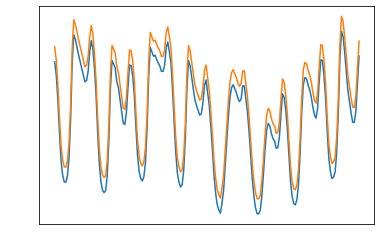

In [132]:
for i in range(2):
    plt.plot(rvs[i][:192] + i*100)

In [41]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,40598,40599,40600,40601,40602,40603,40604,40605,40606,40607
"Demand for Portland General Electric Company (PGE), hourly - UTC time","[20200219T03Z, 2983]","[20200219T02Z, 2802]","[20200219T01Z, 2614]","[20200219T00Z, 2541]","[20200218T23Z, 2543]","[20200218T22Z, 2605]","[20200218T21Z, 2677]","[20200218T20Z, 2753]","[20200218T19Z, 2883]","[20200218T18Z, 3008]",...,None,None,None,None,None,None,None,None,None,None
"Demand for Portland General Electric Company (PGE), hourly - local time","[20200218T19-08, 2983]","[20200218T18-08, 2802]","[20200218T17-08, 2614]","[20200218T16-08, 2541]","[20200218T15-08, 2543]","[20200218T14-08, 2605]","[20200218T13-08, 2677]","[20200218T12-08, 2753]","[20200218T11-08, 2883]","[20200218T10-08, 3008]",...,None,None,None,None,None,None,None,None,None,None
"Actual Net Interchange for Portland General Electric Company (PGE) to Bonneville Power Administration (BPAT), hourly - UTC time","[20200217T08Z, -1382]","[20200217T07Z, -1510]","[20200217T06Z, -1592]","[20200217T05Z, -1697]","[20200217T04Z, -1725]","[20200217T03Z, -1733]","[20200217T02Z, -1716]","[20200217T01Z, -1726]","[20200217T00Z, -1898]","[20200216T23Z, -1940]",...,None,None,None,None,None,None,None,None,None,None
"Actual Net Interchange for Portland General Electric Company (PGE) to PacifiCorp West (PACW), hourly - UTC time","[20200217T08Z, -76]","[20200217T07Z, -79]","[20200217T06Z, -74]","[20200217T05Z, -75]","[20200217T04Z, -66]","[20200217T03Z, -55]","[20200217T02Z, -60]","[20200217T01Z, -58]","[20200217T00Z, -46]","[20200216T23Z, -41]",...,None,None,None,None,None,None,None,None,None,None
"Actual Net Interchange for PacifiCorp West (PACW) to Portland General Electric Company (PGE), hourly - UTC time","[20200217T08Z, 76]","[20200217T07Z, 79]","[20200217T06Z, 74]","[20200217T05Z, 75]","[20200217T04Z, 66]","[20200217T03Z, 55]","[20200217T02Z, 60]","[20200217T01Z, 58]","[20200217T00Z, 46]","[20200216T23Z, 41]",...,None,None,None,None,None,None,None,None,None,None


In [6]:
df_test = pd.read_json('data/EBA/ETA_time.txt')

ValueError: Expected object or value

In [21]:
#load electricity data (after tables been rearranged to use a common time index)
qdf_eba = pd.read_csv('../data/EBA_time.gz', index_col=0, parse_dates=True)

FileNotFoundError: [Errno 2] No such file or directory: '../data/EBA_time.gz'

The time series run from July 1 2015, through Oct 20 2017.
They track the demand, forecast demand and the interchange between ISOs.
For simplicity, I'll focus on Portland and Portland General Electric.

In [18]:
#Select temperature for Portland, OR
msk1=np.array(df_weather['city']=='Portland')
msk2=np.array(df_weather['state']=='OR')

df_pdx_weath=df_weather.loc[msk1&msk2]

In [19]:
#get electricity data for Portland General Electric
msk=df_eba.columns.str.contains('Portland')
df_pdx=df_eba.loc[:,msk]

NameError: name 'df_eba' is not defined

## Plotting data from ISOs

Fortunately the timestamps are all on UTC time, as can be verified by plotting data from opposing sides of the country.
The demand time serie lag by around three hours, as expected.

Net generation for New York Independent System Operator (NYIS), Hourly    15352.0
Net generation for Bonneville Power Administration (BPAT), Hourly         17746.0
dtype: float64


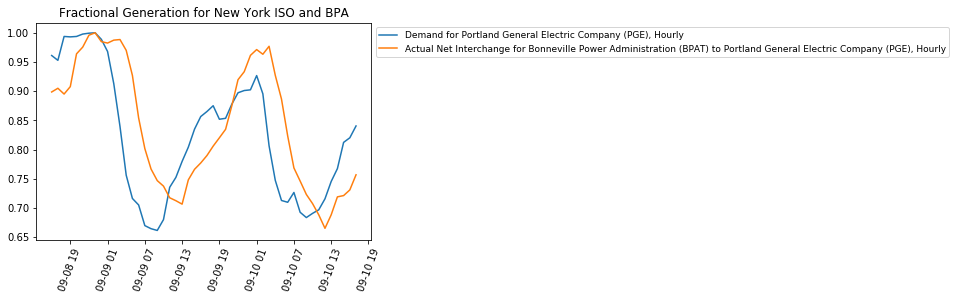

In [25]:
msk1=df_eba.columns.str.contains('Bonneville')
msk2=df_eba.columns.str.contains('New York')
msk3=df_eba.columns.str.contains('generation')
df_dem=df_eba.loc[:,(msk1|msk2)&msk3]
df_sub=df_dem.iloc[-1000:-950,0:5]  #look at 3 days, first 5 columns
df_max = df_sub.max(axis=0)   #scale all variables to so maximum is 1

print(df_max)
f1=plt.figure()
ax=plt.subplot(111)
for i in range(min(5,len(df_sub.columns))):
    ax.plot(df_sub.iloc[:,i]/df_max[i],label=df_sub.columns[i])

ax.legend(df_pdx.columns.values,loc='upper left',bbox_to_anchor=(1,1),prop={'size':9})
plt.title('Fractional Generation for New York ISO and BPA')
plt.xticks(rotation=70)
plt.show()

### Anomaly Detection

A quick look at the Portland data suggests that there are both real outliers, and ones from errors in the data process (100x surrounding values).
The obvious data quality tests are total interchange = 0, and Demand=Net Gen - Net Interchange.

The following example is for Portland, and shows a huge spike in demand in the middle of the day. Is this real or not?  I suspect it is not real: not excessive temperature, not repeated on following days.
Although earlier data showed the same thing at higher 15min time resolution, with a slower ramp up and down.

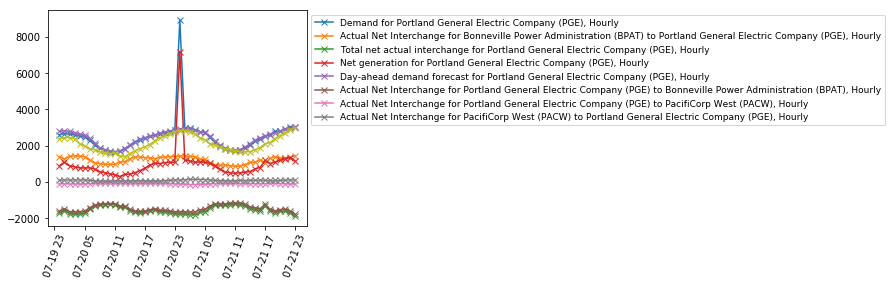

In [21]:
fig=plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.6, 0.75])
ax.plot(df_pdx['2016-07-20':'2016-07-21'],'x-')
ax.legend(df_pdx.columns.values,loc='upper left',bbox_to_anchor=(1,1),prop={'size':9})

ax.plot(10*df_pdx_weath['2016-07-20':'2016-07-21']['Temp'],'x-')
plt.xticks(rotation=70)
#ax.legend(df_pdx.columns.values,loc='upper left',bbox_to_anchor=(1,1),prop={'size':9})

plt.show()

Another set of errors occur for missing values.  There's the section of data from late 2015, when this system was being set up.  A number of these series have this issue.  Otherwise, there are isolated missing data points at midnight.

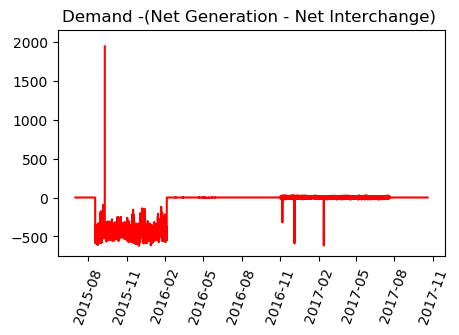

In [46]:
dem=df_pdx.iloc[:,0]
gen=df_pdx.iloc[:,2]
net=df_pdx.iloc[:,3]
fig=plt.figure(figsize=(5,3),dpi=100)
plt.plot(dem-(-gen+net),'r')
plt.title('Demand -(Net Generation - Net Interchange) ')
plt.xticks(rotation=70)
plt.show()

The data in later 2015 seem pretty crappy.  Looking at the EBA user notes, this seems to be a common complaint.
The other errors seem to involve some anomalous zero points in the temperature series.  For temperature series where huge swings are unlikely
it may be feasible to replace anomalous 0 values with the average of the neighbouring points.  In case of actual zero values (such as temperature around freezing), this shouldn't be a large problem, so the temperature stays close to zero.  For anomalous points this should smooth the results.
So we'll just ditch those few months. 

Let's try to clean up some of this data.
My strategy is to find missing values or excessive data.  Find values larger than 3x standard deviations from the mean.

First all true missing values (NA) are with the series mean.
Then extreme values are replaced with the average of two neighbouring points.
I determined extremes as being 4 or more standard deviations away from the mean.  
For weather I used nearest neighbours, and for demand data I used previous/next day.

Why do that?  Sometimes there are whole missing days.  This approach replaces a missing day with the average of yesterday and tomorrow.
The weather data sometimes has isolated missing zero values. Those can be replaced with the average neighbouring values,
which should not be a large distortion if the temperature is actually zero.

This is done using "remove_na", and "avg_extremes" functions from util.py.

## Correlations between demand and weather

The following makes some scatter plots of the demand for Portland, and the weather information gathered at the airport.
The weather variables track temperature, pressure, precipitation, wind and cloud-cover.

In [6]:
#Make a combined Portland Dataframe for demand vs weather.
dem=df_pdx.iloc[:,0].asfreq('H')
dem=avg_extremes(remove_na(dem))
df_joint=pd.DataFrame(dem)
df_joint=df_joint.join(df_pdx_weath)
df_joint.head()
x=df_joint.iloc[:,0]
y=df_joint.iloc[:,1]
df_joint['TempShift']=150+abs(df_joint['Temp']-150)
df_joint=df_joint.rename(columns={df_joint.columns[0]:'Demand'})
#df_joint.head()

Number of NA values 156
Number of extreme values 1. Number of zero values 3


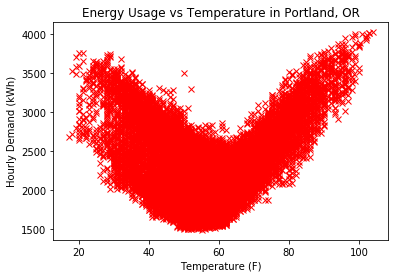

In [74]:
plt.figure()
#plt.plot(df_joint['Temp'],df_joint.iloc[:,0],'rx')
plt.plot(32+9/50*df_joint['Temp'],df_joint.iloc[:,0],'rx')
plt.ylabel('Hourly Demand (kWh)')
#plt.xlabel('Temperature (Celcius x10)')
plt.xlabel('Temperature (F)')
plt.title('Energy Usage vs Temperature in Portland, OR')
plt.savefig('fig/pdx_energy_tempt.png',bbox_inches='tight')
plt.show()

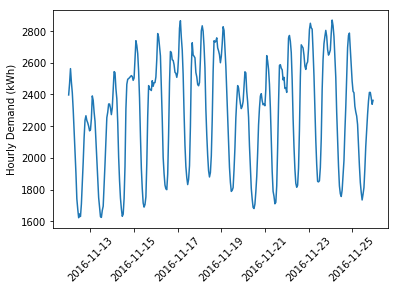

In [72]:
t0=12000
plt.figure()
plt.plot(df_joint.iloc[t0:t0+2*168]['Demand'],'-')
plt.ylabel('Hourly Demand (kWh)')
#plt.xlabel('Temperature (Celcius x10)')
plt.xticks(rotation=45)
plt.savefig('fig/pdx_energy_time.png',bbox_inches='tight')
plt.show()

In [75]:
#Copy figures over to talk dir
!cp fig/*.png /home/jonathan/talks/Metro/fig

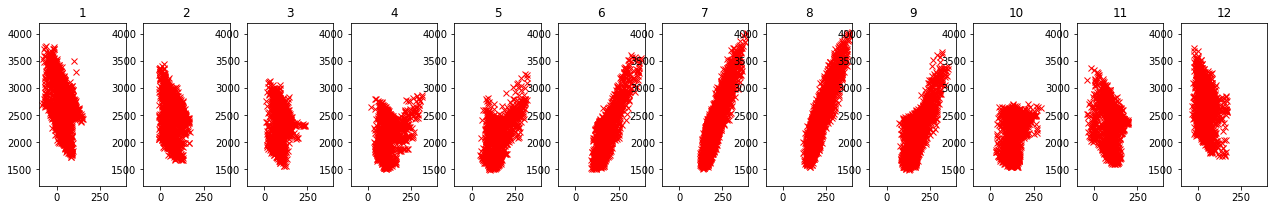

In [36]:
#Try to look for any seasonal effects masking things.  
plt.figure(figsize=(22,3))
for i in range(13):
    msk = (df_joint.index.month==i)
    if (sum(msk)>0):
        df_sub=df_joint.loc[msk]
        plt.subplot(1,12,i)
        plt.plot(df_sub['Temp'],df_sub.iloc[:,0],'rx')
        plt.axis([-100,400,1200,4200])
        plt.title(str(i))

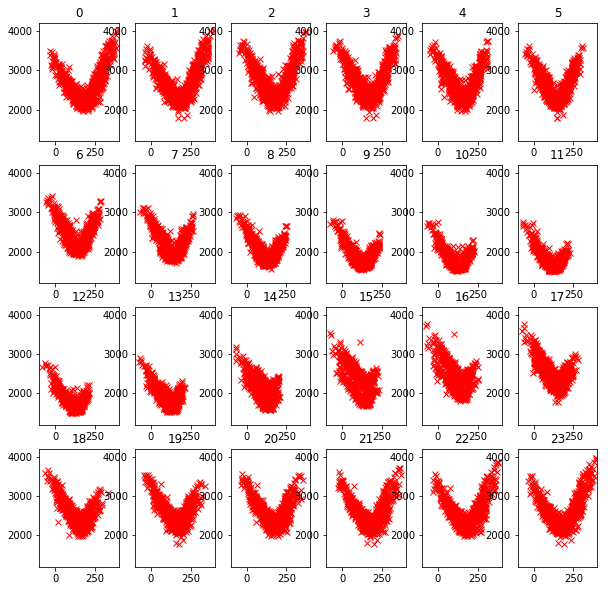

In [77]:
plt.figure(figsize=(10,10))
for i in range(24):
    msk = (df_joint.index.hour==i)
    if (sum(msk)>0):
        df_sub=df_joint.loc[msk]
        plt.subplot(4,6,i+1)
        plt.plot(df_sub['Temp'],df_sub.iloc[:,0],'rx')
        plt.axis([-100,400,1200,4200])
        plt.title(str(i))

0

So the scatterplot for temperature versus demand shows a clear (expected) trend as the temperature becomes excessively hot or cold.
It looks like two blobs with similar slopes for deviations from 15 Celcius.  You can also see anomalous values at zero,
and extremely high values.  I don't know quite what is going on with the low temperatures.  There seems to be a trend,
but with a large spread.
The raw correlation between demand and temperature is very low, but if we introduce a shifted temperature, $T'=|T-T_0|$,
then we capture much more of the variation.

Text(0.5,1,'Energy Usage vs Precipitation in Portland, OR')

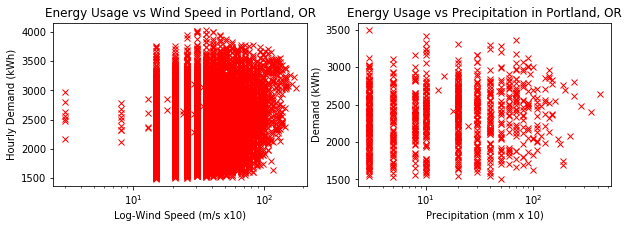

In [54]:
plt.figure(figsize=(10,3))
plt.subplot(121)
plt.semilogx(df_joint['WindSpeed'],df_joint.iloc[:,0],'rx')
plt.xlabel('Log-Wind Speed (m/s x10)')
plt.ylabel('Hourly Demand (kWh)')
plt.title('Energy Usage vs Wind Speed in Portland, OR')
plt.subplot(122)
plt.semilogx(df_joint['Precip-6hr'],df_joint.iloc[:,0],'rx')
plt.ylabel('Demand (kWh)')
plt.xlabel('Precipitation (mm x 10)')
plt.title('Energy Usage vs Precipitation in Portland, OR')

It seems wind/precipitation have no obvious effect. 

Let's also plot the correlation matrix across the whole time series.  Evidently a temperature  deviation from 15 celcius shows the largest correlation, with wind speed being the next most important.
I know the coldest temperatures in some valleys emerge in inversions (with absolutely no air movement), so air does not move and becomes very cold.

In [38]:
pdx_corr=df_joint.corr()

In [39]:
pdx_corr

              Demand  CloudCover   DewTemp  Precip-1hr  Precip-6hr  Pressure  \
Demand      1.000000    0.001337 -0.141752    0.025889    0.059112 -0.069640   
CloudCover  0.001337    1.000000 -0.112792    0.149108    0.178737 -0.131804   
DewTemp    -0.141752   -0.112792  1.000000    0.013433    0.028694 -0.179558   
Precip-1hr  0.025889    0.149108  0.013433    1.000000    0.626609 -0.176323   
Precip-6hr  0.059112    0.178737  0.028694    0.626609    1.000000 -0.307219   
Pressure   -0.069640   -0.131804 -0.179558   -0.176323   -0.307219  1.000000   
Temp        0.088896   -0.259230  0.738031   -0.094895   -0.088351 -0.136697   
WindDir     0.065773   -0.158562  0.270941   -0.074599   -0.044807 -0.009541   
WindSpeed   0.281045    0.086215 -0.280002    0.078901    0.144958 -0.228290   
TempShift   0.644471   -0.075666 -0.455269    0.014048    0.044410 -0.019447   

                Temp   WindDir  WindSpeed  TempShift  
Demand      0.088896  0.065773   0.281045   0.644471  
CloudCove

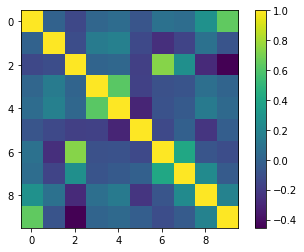

In [16]:
plt.imshow(pdx_corr)
plt.colorbar()
plt.show()

So we'll use a shifted temperature as the prime driver for demand.  

My naive model for how energy usage would vary is a factor for deviation from some ideal temperature, as well as daily and yearly oscillations.
\begin{equation}
    \text{Demand}= A_0+A_T|T-T_0|+A_\text{day}\sin\left( \frac{2\pi t}{24}+\phi_{\text{day}}\right)+A_\text{year}\sin\left(\frac{2\pi d}{365}+\phi_{\text{year}}\right)
\end{equation}
where $t$ is the hour of the day in 24 hour time, and $d$ is the number of days since the start of the year.

To get a sense of those oscillations, let's look at the autocorrelation function for demand, as a function of time.  (Alternatively, the power spectrum?)

# Initial Explorations for Auto regressive modelling

A popular approach assumes that the current demand is probably the same as the previous demand, with some noise.
This is the auto-regressive, integrated, moving average (ARIMA) class of models that are popular linear models within econometric forecasting.

These models assume that seasonality has been removed from the data, and the residuals are delta-correlated, Gaussian noise.
The following employs some checks looking for seasonality.  I had hoped to just use off-the-shelf parts for this,
but python's time-series libraries are fairly limited.

The first seasonal decomposition uses a naive method method that estimates the dominant frequency and decomposes the series into an average seasonal pattern within that period, and average change over a given period, and a residual trend.  For the electricity data driven by temperature as well as daily trends from people, this doesn't quite work.  This method basically captures the daily oscillations but misses the weekly one.

Another requirement for determining an ARIMA model is determining the order of the auto-regression (number of past values to track in predicting future), as well as the moving averages (number of past innovations/noises to track in predicting the future).
This can be done by examining the auto-correlation functions (ACF), as well as the partial auto-correlation functions (PACF).  The time the ACF drops below the noise suggests the order for the auto-regression, and the PACF suggests the order for the moving averages.

In [87]:
from util.EBA_util import make_seasonal_plots, plot_acf

Number of extreme values 0. Number of zero values 0
Number of NA values 0
Number of extreme values 0. Number of zero values 0
Number of NA values 0
(JBM) Freq is  24
(JBM) Freq is  24


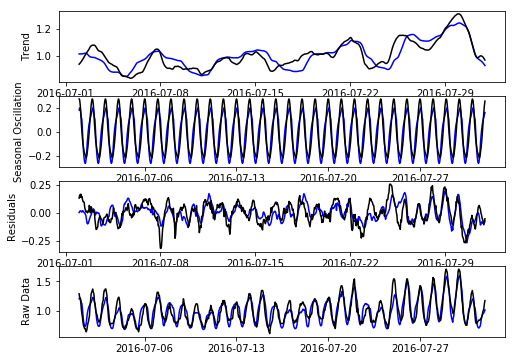

Nlags 50


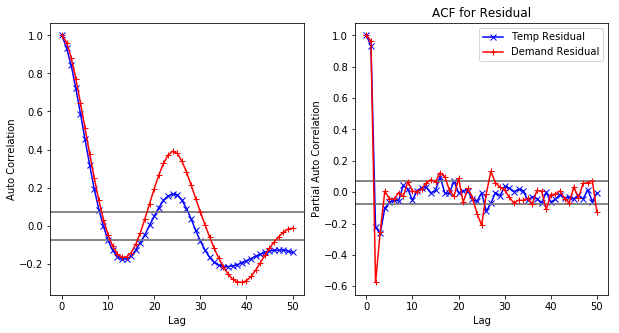

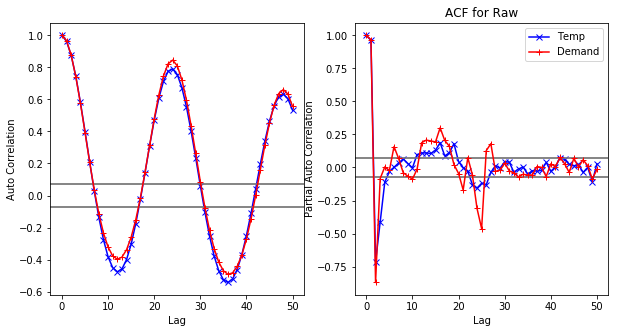

In [137]:
per='2016-07'
dem=df_joint.loc[per,'Demand'].asfreq('H')
dem=avg_extremes(dem,window=24)
dem=remove_na(dem)

temp=df_joint.loc[per,'Temp'].asfreq('H')
temp=avg_extremes(temp)
temp=remove_na(temp)

make_seasonal_plots(dem,temp,per,50)

Evidently, this finds the day timescale.  I'm a bit skeptical of these plots, and this approach of trying a simple seasonality reduction on the whole data set at once.  Worst of all, I think the seasonal component has not been removed.

The autocorrelation plots look at both the temperature and demand for PGE.  The top series is for the residuals, which clearly still show a daily recurrence, while the lower plots are for the raw data.  There is a substantive daily oscillation left by the naive seasonal approach.  This approach assumes a single oscillation, repeated for all time.  In this data however, there is a clear daily signal, which it picks out.  However, this will vary over the course of the year.

.

If we look at the correlation plots for various hours there are a couple clear trends.  Looking at 6pm, shows a really clear weekly (7 day) signal.  This is not as obvious at other times of day (6am, 9am, 12pm).  Note that I have not selected out weekends, or holidays here.  Weekends might be strongly contributing to the weekly oscillation.

Alternatively, take differences at the dominant frequency.  In this case, we would consider changes from 11am from day to day.





Number of extreme values 0. Number of zero values 0
Number of NA values 0
Number of extreme values 0. Number of zero values 7
Number of NA values 2
(JBM) Freq is  7
(JBM) Freq is  7


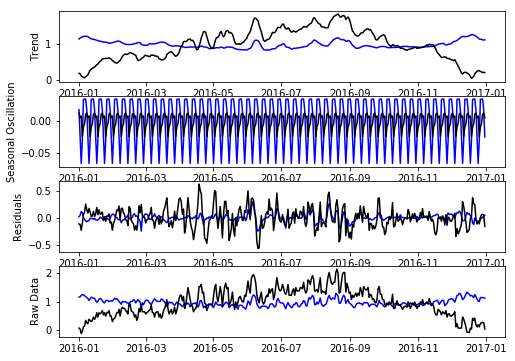

Nlags 20


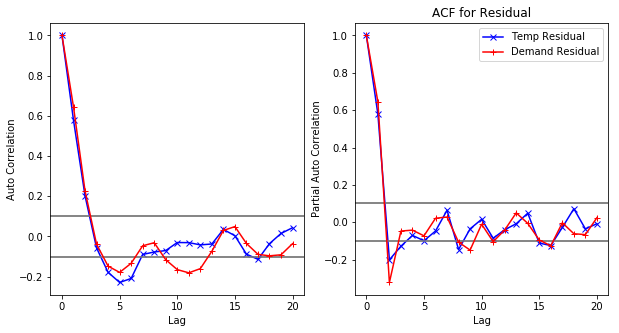

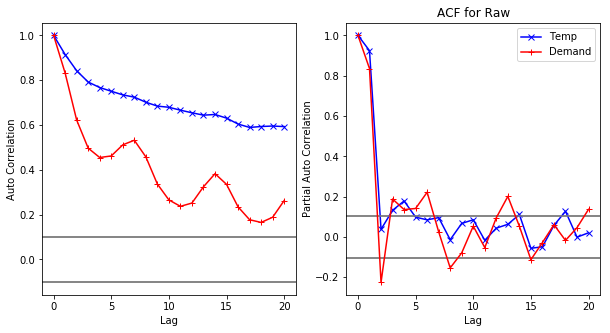

In [140]:
#Compare series at noon  (Note Portland is UTC-8
msk=df_joint.index.hour==4

dem=df_joint[msk]['Demand'].asfreq('D')
dem=avg_extremes(dem)
dem=remove_na(dem)

temp=df_joint[msk]['Temp'].asfreq('D')
temp=avg_extremes(temp)
temp=remove_na(temp)
make_seasonal_plots(dem,temp,'2016',20)

So looking at just a single hour of each day does much better.
The "trend" is effectively picking out the anticipated annual shifts, and the "seasonality" is pulling out a small week long oscillation (the amplitude is much smaller than the trend).  The residuals also seem to be stationary now.

A full model should obviously account for the time of year with
an additional season.  As it stands, we only have a couple of years of data, so we won't go that far.

The raw demand data shows a slowly decaying weekly oscillation.
Even after this attempt to remove the seasonal pattern, there
is still an average significant auto-correlation.

So, this seems to show a large amounts of partial averaging will be required. There is also a weekly oscillation embedded there (more/less usage on weekends).
Basically, any approach relying on fitting a single seasonal patterns
and subtracting it off will fail.  Here, it even seems to lead to
larger correlations on the week timescale. 

## Possible Time Series Methods

So what are our options here for time-series methodology?

On further reflection, the full ARMA approach can be salvaged with multiple seasons, and acknowledging that the demand on any given day is driven by the weather, the time of day, and what day of the week it is.
So in a crude sense, our forecast is something like:
\begin{equation}
  d_{t+1} = d_t+ \alpha_0 (d_{t}-d_{t-1}) +\beta (d_{t-24}-d_{t-25}) + \gamma d_{t-168} + T_t,
\end{equation}
i.e. future demand is the current demand plus a mix of yesterdays and last weeks changes at this hour and last weeks' changes at this hour, with a contribution based on the current temperature.
Note this doesn't really have a nice way to handle holidays explicitly.

Accordingly, we require a method that can handle multiple seasons.
There is already a SARIMAX package developed within statstools.  This could probably be adjusted into handling multiple seasons.

In EBA\_seasonal, I will try to get around this by using a multi-seasonal exponential smoothing approach, which accounts for both the daily and weekly oscillations.  This was the simplest method I could find.
It basically posited multiple seasonal patterns as well as an overall linear trend.
Each of these trends and patterns are then updated (similar to a Kalman filter) at every step.  (It's currently horribly slow to actually run).

Ideally, these approaches should all take vector input to allow
extending this to a single model for the whole system.


# Summary

So that's a lot of work for some fairly elementary findings:
- the strongest covariate with electrical demand is a temperature.
Basically $D \sim |T-T_0|$, with $T_0$ around $15^\circ$ Celcius.
- Demand shows daily, weekly and annual oscillations.

The next notebooks will run with some classic time-series approaches
to modelling this.